# Quantifying contributions of surface forcing to sea level reconstructions and hindcasts, using ECCO adjoint sensitivities

Andrew Delman, updated 2025-06-27

This Jupyter notebook is the starting point for computing sea level contributions from surface forcings (freshwater flux, heat flux, zonal wind stress, meridional wind stress) and associated statistics (e.g., variance, variance explained). When running this notebook, a few Python modules are used which are contained in the `contribs_modules` folder. In order for the modules to be loaded, the `contribs_modules` folder should be included in the same directory as this notebook.

## Input settings

All of the settings that would typically be modified by the user are contained between approximately lines 30 and 380 of the code cell below. This includes parameters such as: 

- Specifiers to identify which types of datasets are being used as pre-initialization (ECCO, ERA5, JRA55-do) or post-initialization (CESM model) forcings. This assumes the data have already been aggregated to weekly means on the ECCO LLC90 model grid. Separate scripts are available in this repository to perform this aggregation and conservative regridding.
- Specifiers for adjoint sensitivity location and maximum lead time to be used.
- Specifiers of years to be included in sea level reconstructions, and whether to remove time mean and trend from reference time series.
- Whether to archive the cell contributions for each year, or only the statistics (variance/variance explained) for each cell.
- The (local) parent directories where the necessary datasets (adjoint sensitivities, forcings, reference time series if used) can be found.
- The output directory and "store" name (in `zarr` format) for the computed sea level contributions and statistics
- Specifiers for any reference time series (optional): observations (altimetry, tide gauges), reconstruction time series.

- The cell "geometry" used to aggregate the impacts from individual ECCO grid cells into larger "cells". Aggregating contributions into larger "cells" or regions can save time and storage space on disk.

Check the comments in the code for additional information about these parameters.

## Cell geometry schemes

The geometry for cell aggregations can be specified in several different ways:

- No aggregation `{'n_merge':1}`:
```
list_nested = []
new_scheme = {'n_merge':1}
already_covered = None
```

- Nested geometry. For example the specification:
```
list_nested = []
# create entry for 1x1 cells (no merging)
new_scheme = {'n_merge':1,'tile':{10:{'j':np.arange(30,90),'i':np.arange(45,90)}}}
list_nested.append(new_scheme)
# create entry for 3x3 cells
new_scheme = {'n_merge':3,'tile':{10:{'j':np.arange(0,90),'i':np.arange(0,90)},\
                                  11:{'j':np.arange(0,90),'i':np.arange(0,30)},\
                                  2:{'j':np.arange(0,45),'i':np.arange(0,30)}}}
list_nested.append(new_scheme)
# create entry for 10x10 cells (remainder of domain)
new_scheme = {'n_merge':10}
already_covered = None
```
  tells the code to compute contributions for individual ECCO cells (no aggregation) for tile 10,
  j indices 30-90, and i indices 45-90, corresponding roughly to the Gulf of Mexico, Caribbean, 
  and NW tropical and mid-Atlantic. 
  Then cells are aggregated 3x3 in 
  the rest of tile 10 (N America and W Atlantic), 
  for tile 11 i indices 0-30 (far southern Caribbean and equatorial region), 
  and tile 2 j indices 0-45, i indices 0-30 (NE tropical and mid-Atlantic).
  Finally, cells are aggregated 10x10 in the rest of the global domain.

- Region specification. You can also be more specific and specify the aggregated "cells" by latitude or longitude limits, to have oblique/diagonal boundaries, or even have distance from a coastline as a boundary. As an example, the `Gulf_NAtl` regional scheme is used in the sea level attribution manuscript, and you can see how this geometry was constructed by looking at the `Gulf_NAtl_regional_scheme` function in the `nested_geoms.py` module. The order of the regions specified matters: if a region is specified first and then another region is specified that overlaps with the first, the first region is preserved.


## Output dataset

After the first code cell below which runs the computation, the second grid cell gives you a sense of the format of the output dataset and associated `zarr` store. (`zarr` is an efficient format for storing and reading data that often reduces the size footprint on disk by a factor of 2-5 vs. `netcdf`, and also is typically faster to read into memory.)

The coordinates in the dataset `ds_forcsens` indicate:
- Times used in adjoint sensitivity computations, forcing, and prediction/reconstruction.
- Latitude (`YC`) and longitude (`XC`) of the ECCO native grid cell centers.
- Latitude (`YG`) and longitude (`XG`) of the ECCO native grid cell min j/min i corner.
- A `cell_indexing` array that maps the aggregated "cell" scheme onto the original ECCO LLC90 grid.
- Latitude (`YC_cell`) and longitude (`XC_cell`) means in the aggregated "cells".
- Latitude (`YG_cell`) and longitude (`XG_cell`) corners of the aggregated "cells" (may not be accurate for cell schemes with oblique boundaries such as `Gulf_NAtl`).

Data variables:

The array `rA_cell` contains the horizontal area in the aggregated "cells".

If the code was run with `cell_impact_years_save = True`, the data variables will include the array `preinit_cell_impact_attimes` which can be quite large and contains the sea level contributions from each "cell", for each forcing type and lead time, at each month and year.

The other statistics can all be derived from `preinit_cell_impact_attimes`, and `obs_tseries_sortmonth` which is the reference time series reshaped so that the month and year dimensions are aligned with the other arrays in the dataset. If a post-initialization forcing is used (from a prediction model), it will be stored in `postinit_cell_impact_attimes`.

If the code was run with `cell_impact_years_save = False` to save storage space, the `preinit_cell_impact_attimes` array is omitted, but the derived statistics such as variance or variance explained can still be seen in the data variables.

For prediction applications, the array `predict_lead_mo` has the predicted sea level at `pred_month` and `pred_year` based on the provided pre- and post-initialization forcings, as a function of the lead time (in months) of the prediction.

In [1]:
"""
Time series and variance/residual variance/variance explained for individual cells 
in adjoint sensitivity-based predictions,
or differences between predictions.
Has support for nested cell geometries.
"""

import numpy as np
import xarray as xr
import dask.array as da
import sys
import os
import shutil
from os.path import join,expanduser,exists
import glob
import multiprocessing

# import supporting Python modules
sys.path.append(join(os.getcwd(),'contribs_modules'))    # change the path to these modules as needed
from forcsens_read import *
from nested_geoms import *
from tseries_ref_load import *
from forcsens_var_cells import *

user_home_dir = expanduser('~')


#========================================================================================
# # # BEGINNING OF TYPICALLY USER-SPECIFIED SETTINGS


# ECCO LLC90 grid file (can be obtained via NASA Earthdata/PO.DAAC, 
# search for ECCO_L4_GEOMETRY_LLC0090GRID_V4R4)
grid_filename = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC','ECCO_L4_GEOMETRY_LLC0090GRID_V4R4',\
                     'GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ds_grid = xr.open_dataset(grid_filename)


# pre-initialization forcing type
forc_pre_type = 'ecco'
if forc_pre_type == 'ecco':
    # # directory containing preinit weekly forcing files
    forc_pre_dir = join(user_home_dir,'Downloads','ECCO_v4r4_adjoint','ecco_forcing')    # weekly ECCOv4r4 surface fluxes (forcing)
elif forc_pre_type == 'era5':
    forc_pre_dir = join(user_home_dir,'Downloads','ERA5','weekly','llc90_grid')     # weekly ERA5 surface fluxes
# pre-initialization river discharge forcing type (set to None or comment out to exclude nonseasonal river discharge)
forc_runoff_pre_type = 'jra55do'

if 'forc_runoff_pre_type' in locals():
    if forc_runoff_pre_type is not None:
        # evap and precip forcing directory, might be sourced separately from wind stress and heat fluxes
        # when river discharge is taken from a different dataset (e.g., JRA55-do).
        if forc_pre_type == 'ecco':
            # weekly evap,precip from ECCOv4r4 central estimate
            forc_ep_pre_dir = join(user_home_dir,'Downloads','ECCO_v4r4_weekly','EPR')
        elif forc_pre_type == 'era5':
            forc_ep_pre_dir = forc_pre_dir
        # # directory containing preinit runoff (river discharge)
        # # if using separate data product from that stored in forc_pre_dir
        forc_runoff_pre_dir = join(user_home_dir,'Downloads','JRA55-do','friver','llc90_grid','weekly')


# # directory containing fluxes to subtract (if differencing two flux datasets)
# forc_pre_sub_type = 'ecco'
# forc_pre_subtract_dir = join(user_home_dir,'Downloads','ECCO_v4r4_adjoint','ecco_forcing')


# # post-initialization forcing type (if applicable, otherwise set to None or comment out)
forc_post_type = None
# forc_post_type = 'cesm_dple_ensmean'
# forc_post_type = 'cesm_hrdp_ensmean'

if 'forc_post_type' in locals():
    if forc_post_type is not None:
        # # directory containing postinit forcing files (i.e., from prediction model hindcasts)
        forc_post_dir = join(user_home_dir,'Downloads','CESM_DPLE','llc90_grid')
        # forc_post_dir = join(user_home_dir,'Downloads','CESM_HRDP','llc90_grid')


# adjoint sensitivities (objective function) location name
adj_sens_loc = 'WesternGulfCoast'


# # parent directories for adjoint sensitivities; sensitivities should be stored in sub-folders 
# # with the location name and objective function time, 
# # e.g., {adj_sens_dir_seas}/{adj_sens_loc}/0104 
# # for the objective function = Jan 2004 relative dynamic sea level mean

# # for seasonally-varying, < 12-month lead time sensitivities
adj_sens_dir_seas = join(expanduser('~'),'Downloads','ECCO_v4r4_adjoint','adjoint_sensitivities')
# # for multi-year, >= 12-month lead time sensitivities
adj_sens_dir_multiyr = join(expanduser('~'),'Downloads','ECCO_v4r4_adjoint','adjoint_sensitivities')


# # reconstruction or prediction sea level location (often the same as adj_sens_loc but may be different)
place_id = 'WesternGulfCoast'
point_or_region = 'region'


# # max weeks lead time to include
# maxlead_id = '12mo'
maxlead_id = '5yr'

if maxlead_id == '12mo':
    max_weeks_lead = 52
elif maxlead_id == '5yr':
    max_weeks_lead = int(np.round(5*(365.24/7)))


# # years included in "predictions" (i.e., sea level reconstructions or hindcasts)
years_to_predict = np.arange(1997,2018)
year_range_id = "_".join([str(year) for year in years_to_predict[[0,-1]]])


# # remove time mean and trend from reference time series?
# # True = remove mean, trend; False = retain mean, trend
trend_remove_opt = False


# # Option to save aggregated cell/regional sea level impacts for each month and year.
# # This should be set to False if cell geometry is not aggregated, i.e., {'n_merge':1} only.
# # For example, archiving ~1e5 individual grid cells globally x 4 forcing types x 100s of lead times x 12 months x 20+ years
# #  = slow runtime and massive storage needs!
cell_impact_years_save = True



# # parent directory (output_dir) and store name (output_storename) for output

output_dir = join(user_home_dir,'Downloads','ECCO_v4r4_adjoint','forcing_stats')

# output_storename = join(output_dir,'ERA5_CESM_DPLE_ensmean_impact_model_'+place_id+'_withtrend_GulfNAtl_regions_'\
#                        +maxlead_id+'_'+year_range_id)
# output_storename = join(output_dir,'ERA5_CESM_DPLE_ensmean_impact_model_'+place_id+'_withtrend_nest10.5.3_'\
#                        +maxlead_id+'_'+year_range_id)
output_storename = join(output_dir,'ECCO_JRA55do_impact_altim_'+place_id+'_withtrend_GulfNAtl_regions_'\
                       +maxlead_id+'_'+year_range_id)
# output_storename = join(output_dir,'ERA5_JRA55do_impact_altim_'+place_id+'_withtrend_GulfNAtl_regions_'\
#                        +maxlead_id+'_'+year_range_id)
# output_storename = join(output_dir,'ECCO_JRA55do_impact_altim_'+place_id+'_withtrend_nest10.5.3_'\
#                        +maxlead_id+'_'+year_range_id)
# output_storename = join(output_dir,'ECCO_JRA55do_impact_altim_'+place_id+'_withtrend_nest10.3.1_'\
#                        +maxlead_id+'_'+year_range_id)
# output_storename = join(output_dir,'ECCO_JRA55do_impact_altim_'+place_id+'_withtrend_tropicsonly_'\
#                        +maxlead_id+'_'+year_range_id)


# Which time series to use as a reference for variance explained calculations?
# Obs (tide gauge, altimetry, models), or reconstr time series based on ECCO or ERA5 fluxes?
# Or specify 'None' to just compute predictions and variance contributions.

# tseries_opt = 'obs_tgauge'
tseries_opt = 'obs_altim'
# tseries_opt = 'model_cesm_dple_ensmean'
# tseries_opt = 'reconstr_ecco'
# tseries_opt = 'reconstr_era5'
# tseries_opt = 'None'



if tseries_opt == 'reconstr_ecco':
    # reconstr_dir = join(user_home_dir,'Documents','Sea_level','predictions')
    # reconstr_path = join(reconstr_dir,adj_sens_loc+'_ECCOv4r4_only_pred')
    reconstr_dir = output_dir
    reconstr_path = join(output_dir,'ECCO_JRA55do_impact_altim_'+place_id+'_withtrend_GulfNAtl_regions_'\
                       +maxlead_id+'_'+year_range_id)
if tseries_opt == 'reconstr_era5':
    # reconstr_dir = join(user_home_dir,'Documents','Sea_level','predictions')
    # reconstr_path = join(reconstr_dir,adj_sens_loc+'_ERA5_unadj_pred_'+year_range_id)
    reconstr_dir = output_dir
    reconstr_path = join(output_dir,'ERA5_JRA55do_impact_altim_'+place_id+'_withtrend_GulfNAtl_regions_'\
                       +maxlead_id+'_'+year_range_id)



# # Preliminary inputs dict (will be augmented later)

inputs = {'forcing_preinit':{'forc_type':forc_pre_type,'forc_dir':forc_pre_dir,\
                             'forc_ep_dir':forc_ep_pre_dir,\
                             'forc_runoff_type':forc_runoff_pre_type,'forc_runoff_dir':forc_runoff_pre_dir,\
# #                              'forc_subtract_type':forc_pre_sub_type,'forc_subtract_dir':forc_pre_subtract_dir,\
                             },\
#           'forcing_postinit':{'forc_type':forc_post_type,'forc_dir':forc_post_dir,\
#                              },\
          'adj_sens_loc':adj_sens_loc,\
          'adj_sens_dir_seas':adj_sens_dir_seas,\
          'adj_sens_dir_multiyr':adj_sens_dir_multiyr,\
          'pred_loc':place_id,\
          'years_to_predict':years_to_predict,\
          'max_weeks_lead':max_weeks_lead,\
          'multiyr_seas_taper_weeks':10,\
          'trend_remove':trend_remove_opt,\
          'cell_impact_years_save':cell_impact_years_save}



# # Create cell aggregation geometry

# list_nested = []
# # create entry for 1x1 cells (no merging)
# # new_scheme = {'n_merge':1,'tile':{10:{'j':np.arange(30,60),'i':np.arange(60,90)}}}
# new_scheme = {'n_merge':1,'tile':{10:{'j':np.arange(30,90),'i':np.arange(45,90)}}}
# list_nested.append(new_scheme)
# # create entry for 3x3 cells
# # new_scheme = {'n_merge':3,'tile':{10:{'j':np.arange(0,90),'i':np.arange(0,90)},\
# #                                   2:{'j':np.arange(0,90),'i':np.arange(0,30)}}}
# new_scheme = {'n_merge':3,'tile':{10:{'j':np.arange(0,90),'i':np.arange(0,90)},\
#                                   11:{'j':np.arange(0,90),'i':np.arange(0,30)},\
#                                   2:{'j':np.arange(0,45),'i':np.arange(0,30)}}}
# list_nested.append(new_scheme)
# # create entry for 10x10 cells (remainder of domain)
# new_scheme = {'n_merge':10}
# already_covered = None

# list_nested = []
# # create entry for 1x1 cells (no merging)
# new_scheme = {'n_merge':1,'tile':{10:[{'j':np.arange(30,90),'i':np.arange(60,90)},\
#                                       {'j':np.arange(50,90),'i':np.arange(0,60)}],\
#                                   11:{'j':np.arange(45,90),'i':np.arange(0,15)},\
#                                   2:{'j':np.arange(0,90),'i':np.arange(0,36)},\
#                                   1:{'j':np.arange(75,90),'i':np.arange(0,36)}}}
# list_nested.append(new_scheme)
# # create entry for 5x5 cells
# new_scheme = {'n_merge':5,'tile':{10:{'j':np.arange(0,90),'i':np.arange(0,90)},\
#                                   11:{'j':np.arange(0,90),'i':np.arange(0,30)},\
#                                   2:{'j':np.arange(0,45),'i':np.arange(0,30)}}}
# list_nested.append(new_scheme)
# # create entry for 10x10 cells (remainder of domain)
# new_scheme = {'n_merge':10}
# already_covered = None




# # N Atlantic only domain
# list_nested = []
# new_scheme = {'n_merge':1,'tile':{10:{'j':np.arange(30,90),'i':np.arange(0,45)},\
#                                   2:{'j':np.arange(45,90),'i':np.arange(0,25)}}}
# list_nested.append(new_scheme)
# new_scheme = {'n_merge':30}
# already_covered = None

# # mid-NE Atlantic only domain
# list_nested = []
# new_scheme = {'n_merge':1,'tile':{2:{'j':np.arange(0,45),'i':np.arange(0,33)}}}
# list_nested.append(new_scheme)
# new_scheme = {'n_merge':30}
# already_covered = None

# # N Med only domain
# list_nested = []
# new_scheme = {'n_merge':1,'tile':{2:{'j':np.arange(30,50),'i':np.arange(33,60)}}}
# list_nested.append(new_scheme)
# new_scheme = {'n_merge':30}
# already_covered = None

# # tropics only domain
# list_nested = []
# new_scheme = {'n_merge':1,'tile':{11:{'j':np.arange(28,90),'i':np.arange(0,22)},\
#                                   1:{'j':np.arange(60,90),'i':np.arange(0,30)}}}
# list_nested.append(new_scheme)
# new_scheme = {'n_merge':30}
# already_covered = None



# GoM and N Atlantic specified regions
list_nested = []
cell_indices_spec,array_indexing_spec,already_covered,\
    XC_cell_spec,YC_cell_spec,XG_cell_spec,YG_cell_spec,rA_cell_spec = Gulf_NAtl_regional_scheme(ds_grid)
# create entry for 10x10 cells
new_scheme = {'n_merge':10,'tile':{10:{'j':np.arange(0,90),'i':np.arange(0,90)},\
                                   2:{'j':np.arange(0,90),'i':np.arange(0,30)}}}
list_nested.append(new_scheme)
# create entry for 30x30 cells (remainder of domain)
new_scheme = {'n_merge':30}
already_covered_spec = np.array(list(already_covered))



# list_nested = []
# # # create entry for 1x1 cells
# new_scheme = {'n_merge':1,'tile':{10:{'j':np.arange(0,90),'i':np.arange(0,90)},\
#                                   11:{'j':np.arange(0,90),'i':np.arange(0,9)}}}
# list_nested.append(new_scheme)
# # create entry for 3x3 cells
# new_scheme = {'n_merge':3,'tile':{2:{'j':np.arange(0,90),'i':np.arange(0,30)},\
#                                    11:{'j':np.arange(0,90),'i':np.arange(9,30)}}}
# list_nested.append(new_scheme)
# # create entry for 30x30 cells (remainder of domain)
# new_scheme = {'n_merge':30}
# already_covered = None


# list_nested = []
# new_scheme = {'n_merge':1}
# already_covered = None



# file locations for reference time series

# # GMSL file paths
file_gmsl_sat_era = join(expanduser('~'),'Downloads','GMSL','MERGED_TP_J1_OSTM_OST_GMSL_ASCII_V51',\
                        'GMSL_TPJAOS_5.1.txt')
file_gmsl_pre_sat = join(expanduser('~'),'Downloads','GMSL','JPL_RECON_GMSL','global_timeseries_measures.nc')

if point_or_region == 'point':
    # tide gauge locations and IDs
    tidegauge_lon = {'Key West': -81.808, 'Fort Myers': -81.872, 'St. Petersburg': -82.627, 'Cedar Key': -83.032,\
                     'Apalachicola': -84.98, 'Pensacola': -87.212, 'Grand Isle': -89.957, 'Galveston': -94.793,\
                     'Rockport': -97.047, 'Port Isabel': -97.215}
    tidegauge_lat = {'Key West': 24.555, 'Fort Myers': 26.648, 'St. Petersburg': 27.762, 'Cedar Key': 29.135,\
                     'Apalachicola': 29.725, 'Pensacola': 30.405, 'Grand Isle': 29.263, 'Galveston': 29.31,\
                     'Rockport': 28.022, 'Port Isabel': 26.062}
    tidegauge_psmsl_id = {'Key West': 188, 'St. Petersburg': 520, 'Pensacola': 246, 'Grand Isle': 526,\
                          'Galveston': 161, 'Port Isabel': 497}
    
    lat_pt = tidegauge_lat[place_id]
    lon_pt = tidegauge_lon[place_id]
    psmsl_id = tidegauge_psmsl_id[place_id]


if tseries_opt == 'obs_tgauge':
    
    # # ERA5 monthly mean SLP (for IB correction)
    file_slp_monthly = join(user_home_dir,'Downloads','ERA5','monthly','ERA5_mon_swind_slp_1950_2023.nc')
    
    
    # # tide gauge data file (text file)
    tgauge_obs_filename = join(expanduser('~'),'Documents','Sea_level','2022_ecco_predict','Data',\
                               str(psmsl_id)+'.rlrdata')

    tseries_ref_kwargs = {'lat_pt':lat_pt,'lon_pt':lon_pt,'psmsl_id':psmsl_id,\
                          'file_slp_monthly':file_slp_monthly,\
                          'file_gmsl_sat_era':file_gmsl_sat_era,\
                          'file_gmsl_pre_sat':file_gmsl_pre_sat,\
                          'tgauge_obs_filename':tgauge_obs_filename}

if tseries_opt == 'obs_altim':
    # location of LLC mask (binary file)
    file_llc_mask = join(expanduser('~'),'Downloads','ECCO_v4r4_adjoint',\
                                            'adjoint_sensitivities',place_id,\
                                            'mask_'+place_id+'.bin')
    
    file_obs_alt_gridded = join(expanduser('~'),'Downloads','Altimetry',\
                                              'MEASURES','2205','MEASURES_tseries_1993_2022.nc')

    tseries_ref_kwargs = {'file_llc_mask':file_llc_mask,\
                          'file_obs_alt_gridded':file_obs_alt_gridded,\
                          'file_gmsl_sat_era':file_gmsl_sat_era}

if 'model_cesm' in tseries_opt:
    # location of model SSH
    if tseries_opt == 'model_cesm_dple_ensmean':        
        ref_dir = join(expanduser('~'),'Downloads','CESM_DPLE','llc90_grid','SSH')
    if tseries_opt == 'model_cesm_hrdp_ensmean':
        ref_dir = join(expanduser('~'),'Downloads','CESM_HRDP','llc90_grid','SSH')

    tseries_ref_kwargs = {'ref_dir':ref_dir,'max_weeks_lead':max_weeks_lead,\
                          'place_id':place_id,'file_grid':grid_filename}

    if point_or_region == 'region':
        # location of LLC mask (binary file)
        file_llc_mask = join(expanduser('~'),'Downloads','ECCO_v4r4_adjoint',\
                                                'adjoint_sensitivities',place_id,\
                                                'mask_'+place_id+'.bin')
        tseries_ref_kwargs['file_llc_mask'] = file_llc_mask
    else:
        tseries_ref_kwargs['lat_pt'] = lat_pt
        tseries_ref_kwargs['lon_pt'] = lon_pt
    

if 'reconstr' in tseries_opt:
    tseries_ref_kwargs = {'reconstr_path':reconstr_path}

tseries_ref_kwargs['file_grid'] = grid_filename




# # # END OF TYPICALLY USER-SPECIFIED SETTINGS
#========================================================================================




# list of forcings
forc_list = ['empmr','qnet','tauu','tauv']

len_j_i = 90    # length of each side of tile

weekly_tbin_centers = np.arange(np.datetime64('2004-01-03T12','ns'),np.datetime64('2005-01-01','ns'),\
                                np.timedelta64(int(7*8.64e13),'ns'))




def forc_seasonal_bins(weekly_tbin_centers,years_to_predict):
    # compute weekly time bin centers
    weeks_ref_to_start = np.round((np.datetime64(str(years_to_predict[0]-1)+'-01-01','ns')\
                                    - np.datetime64('1992-01-01','ns'))\
                                   /np.timedelta64(int(7*8.64e13),'ns')).astype('float64')
    time_bin_center_start = (np.datetime64('1992-01-01','ns') + np.timedelta64(int(3.5*8.64e13),'ns'))\
                            + (weeks_ref_to_start*np.timedelta64(int(7*8.64e13),'ns'))
    time_bin_centers = np.arange(time_bin_center_start,np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns'),\
                                 np.timedelta64(int(7*8.64e13),'ns'))
    
    # sort forcing times into seasonal bins
    forc_hr_end = np.empty((0,))
    forc_datetimes_mid = np.empty((0,),dtype='datetime64[ns]')
    for curr_time in time_bin_centers:
        curr_time_mid = curr_time
        curr_hr_end = ((curr_time_mid + np.timedelta64(int(3.5*8.64e13),'ns') - np.datetime64('1992-01-01','ns'))\
                        .astype('timedelta64[h]')).astype('int64')

        forc_hr_end = np.hstack((forc_hr_end,curr_hr_end))
        forc_datetimes_mid = np.hstack((forc_datetimes_mid,curr_time_mid))

    # forcing time in each year corresponding to forcing seasonal time bin
    closest_forc_hr_to_tbins_0 = np.empty((len(weekly_tbin_centers),len(years_to_predict))).astype('i8')
    closest_forc_hr_to_tbins_1 = np.empty((len(weekly_tbin_centers),len(years_to_predict))).astype('i8')
    for tstep_count,tstep in enumerate(weekly_tbin_centers):
        for year_count,year in enumerate(years_to_predict):
            tbin_center_year = tstep - np.datetime64('2004-01-01','ns') + np.datetime64(str(year)+'-01-01','ns')
            forc_at_tbin_year = np.argmin(np.abs(forc_datetimes_mid - tbin_center_year))
            closest_forc_hr_to_tbins_1[tstep_count,year_count] = int(forc_hr_end[forc_at_tbin_year])

        closest_forc_hr_to_tbins_0[tstep_count,1:] = closest_forc_hr_to_tbins_1[tstep_count,:-1]
        tbin_center_year = tstep - np.datetime64('2004-01-01','ns')\
                                + np.datetime64(str(years_to_predict[0]-1)+'-01-01','ns')
        forc_at_tbin_year = np.argmin(np.abs(forc_datetimes_mid - tbin_center_year))
        closest_forc_hr_to_tbins_0[tstep_count,0] = int(forc_hr_end[forc_at_tbin_year])

    # close any gaps in weekly forcing across Dec-Jan divide
    year_toobig_gap = (closest_forc_hr_to_tbins_1[0,:] - closest_forc_hr_to_tbins_0[-1,:] > (10.5*24)).nonzero()
    closest_forc_hr_to_tbins_0[:,year_toobig_gap] += 168
    
    return forc_hr_end,forc_datetimes_mid,closest_forc_hr_to_tbins_0,closest_forc_hr_to_tbins_1



def closest_forc_to_sens(weekly_tbin_centers,years_to_predict,closest_forc_hr_to_tbins_0,closest_forc_hr_to_tbins_1):
    
    year_timedelta = np.timedelta64(int(365.24*8.64e13),'ns')
    
    sens_time = np.empty((12,55),dtype='datetime64[ns]')
    sens_time.fill(np.datetime64('NaT'))
    pred_time = np.empty((12,len(years_to_predict)),dtype='datetime64[ns]')
    pred_time.fill(np.datetime64('NaT'))
    closest_forc_to_sens_tstep = np.empty((12,55),dtype=np.int64)
    closest_forc_to_sens_tstep.fill(-1000000)
    closest_forc_to_sens_atyears = np.empty((12,55,len(years_to_predict)),dtype='datetime64[ns]')
    closest_forc_to_sens_atyears.fill(np.datetime64('NaT'))
    for pred_count,pred_month in enumerate(range(1,13)):
        sens,sens_tstep_times = adj_sens_read('empmr',adj_sens_dir_seas,adj_sens_loc,pred_month)
        sens_time[pred_count,:len(sens_tstep_times)] = sens_tstep_times
        for year_count,year in enumerate(years_to_predict):
            pred_time[pred_count,year_count] = np.datetime64(str(year)+'-'+str(pred_month).rjust(2,'0')+'-15','ns')

        for tstep_count,sens_tstep in enumerate(sens_tstep_times):
            abs_tdist = np.abs(((weekly_tbin_centers - sens_tstep + (year_timedelta/2)) % year_timedelta)\
                               - (year_timedelta/2))
            closest_tdist = np.argmin(abs_tdist)
            closest_forc_to_sens_tstep[pred_count,tstep_count] = closest_tdist
            # match forcing and sensitivity years
            if closest_tdist >= tstep_count:
                closest_forc_hr_to_sens_tstep = closest_forc_hr_to_tbins_0[closest_tdist,:]
            elif closest_tdist < tstep_count - (len(sens_tstep_times) - 5):
                tbin_center_year = weekly_tbin_centers[closest_tdist] - np.datetime64('2004-01-01','ns')\
                                    + np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns')
                forc_at_tbin_year = np.argmin(np.abs(forc_datetimes_mid - tbin_center_year))
                closest_forc_hr_to_sens_tstep = np.hstack((closest_forc_hr_to_tbins_1[closest_tdist,1:],\
                                                           np.array([int(forc_hr_end[forc_at_tbin_year])])))
            else:
                closest_forc_hr_to_sens_tstep = closest_forc_hr_to_tbins_1[closest_tdist,:]
            closest_forc_to_sens_atyears[pred_count,tstep_count,:] = np.datetime64('1992-01-01','ns')\
                                    + closest_forc_hr_to_sens_tstep.astype('timedelta64[h]')\
                                    - np.timedelta64(int(3.5*8.64e13),'ns')
    
    return sens_time,pred_time,closest_forc_to_sens_tstep,closest_forc_to_sens_atyears



def closest_forc_to_sens_multiyr(years_to_predict,pred_time,max_weeks_lead):
    
    year_timedelta = np.timedelta64(int(365.24*8.64e13),'ns')
    week_timedelta = np.timedelta64(int(7*8.64e13),'ns')
    base_week_center = np.datetime64('1992-01-04T12:00:00','ns')
    
    sens_multiyr,sens_tstep_times_multiyr = adj_sens_read_multiyr('empmr',adj_sens_dir_multiyr,adj_sens_loc)
    sens_tstep_times_multiyr = sens_tstep_times_multiyr[-(max_weeks_lead+5):]
    
    closest_forc_to_sens_atyears_multiyr = np.empty((12,max_weeks_lead+5,len(years_to_predict)),\
                                            dtype='datetime64[ns]')
    closest_forc_to_sens_atyears_multiyr.fill(np.datetime64('NaT'))
    for tstep_count,sens_tstep in enumerate(sens_tstep_times_multiyr):
        curr_lead_time = np.datetime64('2015-12-16T12:00:00','ns') - sens_tstep
        if (curr_lead_time/week_timedelta) > max_weeks_lead + 0.5:
            continue
        for month_count,pred_month in enumerate(range(1,13)):            
            curr_pred_times = pred_time[month_count,:]
            curr_forc_target_times = curr_pred_times - curr_lead_time

            closest_forc_to_sens_atyears_multiyr[month_count,tstep_count,:] = \
                                        (np.round((curr_forc_target_times - base_week_center - np.timedelta64(1,'m'))\
                                            /week_timedelta)*week_timedelta) + base_week_center
    
    good_tstep_ind = (np.sum(np.sum(~np.isnan(closest_forc_to_sens_atyears_multiyr),axis=-1),axis=0)\
                      > 0.5).nonzero()[0]
    sens_time_multiyr = sens_tstep_times_multiyr[np.nanmin(good_tstep_ind):]
    closest_forc_to_sens_atyears_multiyr = \
                        closest_forc_to_sens_atyears_multiyr[:,np.nanmin(good_tstep_ind):,:]
    
    return sens_time_multiyr,closest_forc_to_sens_atyears_multiyr
        
    

# # load reference time series (obs, reconstr, or model)

ref_outputs = tseries_reference(tseries_opt,inputs['years_to_predict'],\
                                             **tseries_ref_kwargs)
ref_tseries,ref_datetime = ref_outputs[:2]
if len(ref_outputs) > 2:
    ref_init_time = ref_outputs[2]


# filling out list_nested for cell indexing scheme
if (('n_merge' in new_scheme.keys()) and ('tile' not in new_scheme.keys())):
    allind_dict = {'j':np.arange(0,90),'i':np.arange(0,90)}
    newind_dict = {}
    for tile in range(13):
        newind_dict = {**newind_dict,**{tile:allind_dict}}
    new_scheme = {**new_scheme,**{'tile':newind_dict}}
    list_nested.append(new_scheme)


# specifying whether cell indexing scheme consists of all 1x1 groupings
if ((len(list_nested) == 1) and (list_nested[0]['n_merge'] == 1)):
    inputs = {**inputs,**{'cells_all_single':True}}
else:
    inputs = {**inputs,**{'cells_all_single':False}}



# generate cell indices and coordinates for new geometry
cell_indices,array_indexing,incell_order,XC_cell,YC_cell,XG_cell,YG_cell,rA_cell = \
  nested_geom_create(list_nested,ds_grid.XC.values,ds_grid.YC.values,ds_grid.XG.values,ds_grid.YG.values,\
                     (ds_grid.hFacC.isel(k=0)*ds_grid.rA).values,already_covered)



# combine specific and generic cell grouping schemes, if applicable
if 'cell_indices_spec' in locals():
    cell_indices = cell_indices_spec + cell_indices
    array_indexing_spec[already_covered_spec < 0.5] = array_indexing[already_covered_spec < 0.5]\
                                                        + np.nanmax(array_indexing_spec) + 1
    array_indexing = array_indexing_spec
    XC_cell = np.hstack((XC_cell_spec,XC_cell))
    YC_cell = np.hstack((YC_cell_spec,YC_cell))
    XG_cell = np.hstack((XG_cell_spec,XG_cell))
    YG_cell = np.hstack((YG_cell_spec,YG_cell))
    rA_cell = np.hstack((rA_cell_spec,rA_cell))

n_cells = len(cell_indices)




# # identify/associate forcing and sensitivity time steps

# sort forcing times into seasonal bins
forc_hr_end,forc_datetimes_mid,closest_forc_hr_to_tbins_0,closest_forc_hr_to_tbins_1 = \
            forc_seasonal_bins(weekly_tbin_centers,years_to_predict)


# associate forcing with sensitivity time steps
sens_time,pred_time,closest_forc_to_sens_tstep,closest_forc_to_sens_atyears = closest_forc_to_sens(\
                weekly_tbin_centers,years_to_predict,closest_forc_hr_to_tbins_0,closest_forc_hr_to_tbins_1)
inputs['sens_time'] = sens_time
inputs['closest_forc_to_sens_atyears'] = closest_forc_to_sens_atyears

# associate forcing with multi-year sensitivity time steps
if max_weeks_lead > 52:
    sens_time_multiyr,closest_forc_to_sens_atyears_multiyr = closest_forc_to_sens_multiyr(\
                                                    years_to_predict,pred_time,max_weeks_lead)
    inputs['sens_time_multiyr'] = sens_time_multiyr
    inputs['closest_forc_to_sens_atyears_multiyr'] = closest_forc_to_sens_atyears_multiyr



# Update inputs dict
inputs['cell_indices'] = cell_indices
if 'obs' in tseries_opt:
    inputs = {**inputs,**{'obs':{'tseries':ref_tseries,'datetime':ref_datetime}}}
if 'reconstr' in tseries_opt:
    inputs = {**inputs,**{'reconstr':{'tseries':ref_tseries,'datetime':ref_datetime}}}
if 'model' in tseries_opt:
    inputs = {**inputs,**{'model':{'tseries':ref_tseries,'datetime':ref_datetime}}}
  


if 'forcing_postinit' in inputs.keys():
    if 'seas5_ensmean' in inputs['forcing_postinit']['forc_type']:
        n_postinit_leads = 8
    elif 'cesm_dple_ensmean' in inputs['forcing_postinit']['forc_type']:
        n_postinit_leads = 6
    elif 'cesm_hrdp_ensmean' in inputs['forcing_postinit']['forc_type']:
        n_postinit_leads = 3


# compute cell-specific impacts and variances
if __name__ == '__main__':
    
    # Use multiprocessing to parallelize sens*forc convolution computation    
    if cell_impact_years_save == True:
        
        pool = multiprocessing.Pool(4)
        results_list = []
        for forc_num,curr_forc in enumerate(forc_list):
            results_list.append(pool.apply_async(forcsens_var_cells,[{**{'curr_forc':curr_forc},**inputs}]))
            # # can use this line instead of the above if not using multiprocessing
            # results_list.append(forcsens_var_cells({**{'curr_forc':curr_forc},**inputs}))
        pool.close()
        pool.join()
        
        for forc_num,curr_result in enumerate(results_list):
            outputs = curr_result.get()
            # # use this line instead of the above if not using multiprocessing
            # outputs = curr_result
            if forc_num == 0:
                preinit_cell_impact_attimes = np.empty((len(forc_list),)+outputs[0]['preinit'].shape,\
                                                       dtype=np.float32)
                preinit_cell_impact_attimes.fill(np.nan)
            preinit_cell_impact_attimes[forc_num,:,:,:,:] = outputs[0]['preinit']
            if 'forcing_postinit' in inputs.keys():
                if forc_num == 0:
                    postinit_cell_impact_attimes = np.empty((n_postinit_leads,len(forc_list))\
                                                            +outputs[0]['postinit'].shape[1:],\
                                                            dtype=np.float32)
                    postinit_cell_impact_attimes.fill(np.nan)
                postinit_cell_impact_attimes[:,forc_num,:,:,:,:] = outputs[0]['postinit']
            
            if ('obs' in inputs.keys()) or ('reconstr' in inputs.keys()) or ('model' in inputs.keys()):
                if 'forcing_postinit' in inputs.keys():
                    if forc_num == 0:
                        resid_cell_impact_var = np.empty((n_postinit_leads,len(forc_list))\
                                                         +outputs[1].shape[1:])
                        resid_cell_impact_var.fill(np.nan)
                        cum_resid_cell_impact_var = np.empty((n_postinit_leads,len(forc_list))\
                                                             +outputs[2].shape[1:])
                        cum_resid_cell_impact_var.fill(np.nan)
                    resid_cell_impact_var[:,forc_num,:,:,:] = outputs[1]
                    cum_resid_cell_impact_var[:,forc_num,:,:,:] = outputs[2]
                else:
                    if forc_num == 0:
                        resid_cell_impact_var = np.empty((len(forc_list),)+outputs[1].shape)
                        resid_cell_impact_var.fill(np.nan)
                        cum_resid_cell_impact_var = np.empty((len(forc_list),)+outputs[2].shape)
                        cum_resid_cell_impact_var.fill(np.nan)
                    resid_cell_impact_var[forc_num,:,:,:] = outputs[1]
                    cum_resid_cell_impact_var[forc_num,:,:,:] = outputs[2]
            else:
                if 'forcing_postinit' in inputs.keys():
                    if forc_num == 0:
                        cell_impact_var = np.empty((n_postinit_leads,len(forc_list))\
                                                   +outputs[1].shape[1:])
                        cell_impact_var.fill(np.nan)
                        cum_cell_impact_var = np.empty((n_postinit_leads,len(forc_list))\
                                                       +outputs[2].shape[1:])
                        cum_cell_impact_var.fill(np.nan)
                    cell_impact_var[:,forc_num,:,:,:] = outputs[1]
                    cum_cell_impact_var[:,forc_num,:,:,:] = outputs[2]
                else:
                    if forc_num == 0:
                        cell_impact_var = np.empty((len(forc_list),)+outputs[1].shape)
                        cell_impact_var.fill(np.nan)
                        cum_cell_impact_var = np.empty((len(forc_list),)+outputs[2].shape)
                        cum_cell_impact_var.fill(np.nan)
                    cell_impact_var[forc_num,:,:,:] = outputs[1]
                    cum_cell_impact_var[forc_num,:,:,:] = outputs[2]
            if forc_num == 0:
                if 'forcing_postinit' in inputs.keys():
                    forcing_postinit_init_array = outputs[-3]
                sens_times_all = outputs[-2]
                closest_forc_to_sens_atyears_all = outputs[-1]
        
        preinit_impact_forc_senststep_attimes = np.nansum(preinit_cell_impact_attimes,axis=-1)
        if 'forcing_postinit' in inputs.keys():
            postinit_impact_forc_senststep_attimes = np.nansum(postinit_cell_impact_attimes,axis=-1)
    else:
        n_segs = 13
        len_seg = int(np.ceil(n_cells/n_segs))
        curr_inputs = inputs
        del curr_inputs['cell_indices']
        for seg_count in range(n_segs):
            cell_ind_in_seg = np.arange(seg_count*len_seg,np.fmin(n_cells,(seg_count+1)*len_seg))
            curr_cell_indices = cell_indices[(seg_count*len_seg):np.fmin(n_cells,(seg_count+1)*len_seg)]            
            pool = multiprocessing.Pool()
            results_list = []
            import time
            time_log = [time.time()]
            for forc_num,curr_forc in enumerate(forc_list):
                results_list.append(pool.apply_async(forcsens_var_cells,[{**{'curr_forc':curr_forc,\
                                                         'cell_indices':curr_cell_indices},\
                                                          **curr_inputs}]))
            
            pool.close()
            pool.join()
            
            for forc_num,curr_result in enumerate(results_list):
                outputs = curr_result.get()
                if ((seg_count == 0) and (forc_num == 0)):
                    preinit_impact_forc_senststep_attimes = np.empty((len(forc_list),)\
                                                                     +outputs[0]['preinit'].shape)
                    preinit_impact_forc_senststep_attimes.fill(np.nan)
                preinit_impact_forc_senststep_attimes[forc_num,:,:,:] += outputs[0]['preinit']
                if 'forcing_postinit' in inputs.keys():
                    if ((seg_count == 0) and (forc_num == 0)):
                        postinit_impact_forc_senststep_attimes = np.empty((n_postinit_leads,len(forc_list))\
                                                                          +outputs[0]['postinit'].shape[1:])
                        postinit_impact_forc_senststep_attimes.fill(np.nan)
                    postinit_impact_forc_senststep_attimes[:,forc_num,:,:,:] += outputs[0]['postinit']
                if ('obs' in inputs.keys()) or ('reconstr' in inputs.keys()) or ('model' in inputs.keys()):
                    if 'forcing_postinit' in inputs.keys():
                        if ((seg_count == 0) and (forc_num == 0)):
                            resid_cell_impact_var = np.empty((n_postinit_leads,len(forc_list))\
                                                             +outputs[1].shape[1:3]+(len(cell_indices),))
                            resid_cell_impact_var.fill(np.nan)
                            cum_resid_cell_impact_var = np.empty((n_postinit_leads,len(forc_list))\
                                                                 +outputs[2].shape[1:3]+(len(cell_indices),))
                            cum_resid_cell_impact_var.fill(np.nan)
                        resid_cell_impact_var[forc_num,:,:,cell_ind_in_seg] = np.moveaxis(outputs[1],-1,0)
                        cum_resid_cell_impact_var[forc_num,:,:,cell_ind_in_seg] = np.moveaxis(outputs[2],-1,0)
                    else:
                        if ((seg_count == 0) and (forc_num == 0)):
                            resid_cell_impact_var = np.empty((len(forc_list),)\
                                                             +outputs[1].shape[0:2]+(len(cell_indices),))
                            resid_cell_impact_var.fill(np.nan)
                            cum_resid_cell_impact_var = np.empty((len(forc_list),)\
                                                                 +outputs[2].shape[0:2]+(len(cell_indices),))
                            cum_resid_cell_impact_var.fill(np.nan)
                        resid_cell_impact_var[forc_num,:,:,cell_ind_in_seg] = np.moveaxis(outputs[1],-1,0)
                        cum_resid_cell_impact_var[forc_num,:,:,cell_ind_in_seg] = np.moveaxis(outputs[2],-1,0)
                    
                else:
                    if 'forcing_postinit' in inputs.keys():
                        if ((seg_count == 0) and (forc_num == 0)):
                            cell_impact_var = np.empty((n_postinit_leads,len(forc_list))\
                                                       +outputs[1].shape[1:3]+(len(cell_indices),))
                            cell_impact_var.fill(np.nan)
                            cum_cell_impact_var = np.empty((n_postinit_leads,len(forc_list))\
                                                           +outputs[2].shape[1:3]+(len(cell_indices),))
                            cum_cell_impact_var.fill(np.nan)
                        cell_impact_var[:,forc_num,:,:,cell_ind_in_seg] = np.moveaxis(outputs[1],-1,0)
                        cum_cell_impact_var[:,forc_num,:,:,cell_ind_in_seg] = np.moveaxis(outputs[2],-1,0)
                    else:
                        if ((seg_count == 0) and (forc_num == 0)):
                            cell_impact_var = np.empty((len(forc_list),)\
                                                       +outputs[1].shape[1:3]+(len(cell_indices),))
                            cell_impact_var.fill(np.nan)
                            cum_cell_impact_var = np.empty((len(forc_list),)\
                                                           +outputs[2].shape[1:3]+(len(cell_indices),))
                            cum_cell_impact_var.fill(np.nan)
                        cell_impact_var[forc_num,:,:,cell_ind_in_seg] = np.moveaxis(outputs[1],-1,0)
                        cum_cell_impact_var[forc_num,:,:,cell_ind_in_seg] = np.moveaxis(outputs[2],-1,0)
                if ((seg_count == 0) and (forc_num == 0)):
                    if 'forcing_postinit' in inputs.keys():
                        forcing_postinit_init_array = outputs[-3]
                    sens_times_all = outputs[-2]
                    closest_forc_to_sens_atyears_all = outputs[-1]

            time_log.append(time.time())
            print(np.diff(np.asarray(time_log)[-2:]))


# DataArrays for adj sensitivity and forcing times
sens_time = xr.DataArray(sens_times_all,dims=['pred_month','sens_tval'])
closest_forc_to_sens_atyears = xr.DataArray(closest_forc_to_sens_atyears_all,\
                                            dims=['pred_month','sens_tval','pred_year'])

# DataArray for impacts/contributions from pre-initialization forcing
preinit_impact_forc_senststep_attimes = \
            xr.DataArray(preinit_impact_forc_senststep_attimes,\
                         dims=['forc','pred_month','sens_tval','pred_year'])

# sum impacts over sens tsteps and forcings
preinit_all_impact_forc_attimes = preinit_impact_forc_senststep_attimes.sum('sens_tval')
preinit_all_impact_senststep_attimes = preinit_impact_forc_senststep_attimes.sum('forc')
if 'forcing_postinit' in inputs.keys():
    postinit_init_time = xr.DataArray(forcing_postinit_init_array,\
                                             dims=['lead_num','pred_month','sens_tval','pred_year'])
    postinit_init_time = postinit_init_time.assign_attrs(\
                                            {'long_name':'Initialization date for '\
                                                            +'postinit prediction model'})
    postinit_impact_forc_senststep_attimes = \
                xr.DataArray(postinit_impact_forc_senststep_attimes,\
                             dims=['lead_num','forc','pred_month','sens_tval','pred_year'])
    postinit_all_impact_forc_attimes = postinit_impact_forc_senststep_attimes.sum('sens_tval')
    postinit_all_impact_senststep_attimes = postinit_impact_forc_senststep_attimes.sum('forc')

    postinit_mask = ((closest_forc_to_sens_atyears - postinit_init_time)\
                     .transpose('lead_num','pred_month','sens_tval','pred_year').values\
                     > np.timedelta64(0,'ns')).astype('float64')                        
    postinit_mask = xr.DataArray(postinit_mask,dims=['lead_num','pred_month','sens_tval','pred_year'])


def preinit_postinit_sum(da_preinit,da_postinit,da_postinit_mask):
    da_sum = ((1 - da_postinit_mask)*da_preinit) + (da_postinit_mask*da_postinit)

    return da_sum

def cum_preinit_sum(da_preinit):
    tstep_dimnum = [dimnum for dimnum,dimname in enumerate(da_preinit.dims)\
                    if dimname == 'sens_tval'][0]
    tstep_dimlen = da_preinit.sizes['sens_tval']
    cum_sum = np.empty(da_preinit.shape)
    cum_sum.fill(np.nan)
    da_cum_sum = xr.DataArray(cum_sum,dims=da_preinit.dims)
    for tstep_count in range(tstep_dimlen):
        indexing_tup = ((slice(None),)*tstep_dimnum) + (tstep_count,)\
                        + ((slice(None),)*(len(da_cum_sum.shape) - tstep_dimnum - 1))
        da_cum_sum[indexing_tup] = da_preinit.isel(sens_tval=slice(0,tstep_count+1)).sum('sens_tval')

    return da_cum_sum

def cum_preinit_postinit_sum(da_preinit,da_postinit):
    tstep_dimnum = [dimnum for dimnum,dimname in enumerate(da_postinit.dims)\
                    if dimname == 'sens_tval'][0]
    tstep_dimlen = da_postinit.sizes['sens_tval']
    cum_sum = np.empty(da_postinit.shape)
    cum_sum.fill(np.nan)
    da_cum_sum = xr.DataArray(cum_sum,dims=da_postinit.dims)
    for tstep_count in range(tstep_dimlen):
        indexing_tup = ((slice(None),)*tstep_dimnum) + (tstep_count,)\
                        + ((slice(None),)*(len(da_cum_sum.shape) - tstep_dimnum - 1))
        if tstep_count == tstep_dimlen - 1:
            da_cum_sum[indexing_tup] = da_preinit.isel(sens_tval=slice(0,tstep_count+1)).sum('sens_tval')
        else:
            da_cum_sum[indexing_tup] = da_preinit.isel(sens_tval=slice(0,tstep_count+1)).sum('sens_tval')\
                                + da_postinit.isel(sens_tval=slice(tstep_count+1,None)).sum('sens_tval')

    return da_cum_sum


# # time series of predictions from monthly lead times
lead_mo = np.arange(0.5,(7*max_weeks_lead)/(365.24/12),1)
predict_init_time = np.empty(((preinit_all_impact_senststep_attimes.squeeze()).shape[0::2]+(len(lead_mo),)),\
                             dtype='datetime64[ns]')
predict_init_time.fill(np.datetime64('NaT'))

predict_lead_mo = np.empty(((preinit_all_impact_senststep_attimes.squeeze()).shape[0::2]+(len(lead_mo),)))
predict_lead_mo.fill(np.nan)
for curr_count,curr_lead_mo in enumerate(lead_mo):
    pred_init_time = np.expand_dims(pred_time,axis=1)\
                        - np.timedelta64(int((365.24/12)*curr_lead_mo*(8.64e13)),'ns')
    in_preinit_range = (closest_forc_to_sens_atyears.values - pred_init_time <= np.timedelta64(0,'ns'))
    curr_predict_init_time = np.nanmax(np.where(in_preinit_range,\
                                                   closest_forc_to_sens_atyears.values,\
                                                   closest_forc_to_sens_atyears.values[:,[0],:]\
                                                    - np.timedelta64(7,'D')),axis=1)\
                                            + np.timedelta64(int(3.5*8.64e13),'ns')    
    predict_init_time[:,:,curr_count] = curr_predict_init_time
    predict_lead_mo[...,curr_count] = (np.nansum(in_preinit_range\
                                                 *preinit_all_impact_senststep_attimes,axis=1)).squeeze()
    if 'forcing_postinit' in inputs.keys():
        at_or_before_init = (postinit_init_time.values\
                                - np.expand_dims(predict_init_time[:,:,curr_count],axis=(0,2))\
                                 < np.timedelta64(5,'D'))
        postinit_curr_init = np.nanmax(np.where(at_or_before_init,\
                                                 postinit_init_time.values,\
                                                 np.datetime64('NaT')),axis=(2,0),keepdims=True)
        at_curr_init = (np.abs(postinit_init_time.values - postinit_curr_init) < np.timedelta64(2,'D'))
        postinit_predlead = np.expand_dims(closest_forc_to_sens_atyears.values,axis=0)\
                                           - postinit_curr_init
        in_postinit_range = np.expand_dims(~in_preinit_range,axis=0)
        predict_lead_mo[...,curr_count] += np.nansum(at_curr_init*in_postinit_range\
                                                      *postinit_all_impact_senststep_attimes,axis=(2,0))

predict_lead_mo = xr.DataArray(predict_lead_mo,dims=['pred_month','pred_year','lead_mo'])


if 'forcing_postinit' in inputs.keys():
    impact_forc_senststep_attimes = preinit_postinit_sum(preinit_impact_forc_senststep_attimes,\
                                                         postinit_impact_forc_senststep_attimes,\
                                                         postinit_mask)
    all_impact_forc_attimes = preinit_postinit_sum(preinit_all_impact_forc_attimes,\
                                                   postinit_all_impact_forc_attimes,\
                                                   postinit_mask)
    all_impact_senststep_attimes = preinit_postinit_sum(preinit_all_impact_senststep_attimes,\
                                                        postinit_all_impact_senststep_attimes,\
                                                        postinit_mask)
else:
    impact_forc_senststep_attimes = preinit_impact_forc_senststep_attimes
    all_impact_forc_attimes = preinit_all_impact_forc_attimes
    all_impact_senststep_attimes = preinit_all_impact_senststep_attimes



if ('obs' in inputs.keys()) or ('reconstr' in inputs.keys()) or ('model' in inputs.keys()):

    if 'forcing_postinit' in inputs.keys():
        resid_cell_impact_var = xr.DataArray(resid_cell_impact_var,\
                                             dims=['lead_num','forc','pred_month','sens_tval','cell'])
        cum_resid_cell_impact_var = xr.DataArray(cum_resid_cell_impact_var,\
                                             dims=['lead_num','forc','pred_month','sens_tval','cell'])
    else:
        resid_cell_impact_var = xr.DataArray(resid_cell_impact_var,\
                                             dims=['forc','pred_month','sens_tval','cell'])
        cum_resid_cell_impact_var = xr.DataArray(cum_resid_cell_impact_var,\
                                             dims=['forc','pred_month','sens_tval','cell'])

    
    # sorting reference time series (e.g., obs, reconstr, model)
    # and cell-specific residual variances summed across forcings (only if cell_impact_years_save = True)
    
    if len(ref_tseries.shape) > 1:
        curr_lead_dimlen = ref_tseries.shape[0]
        ref_tseries_sortmonth = np.empty((curr_lead_dimlen,12,len(years_to_predict)))
        ref_init_time_sortmonth = np.empty((curr_lead_dimlen,12,len(years_to_predict)),dtype='datetime64[ns]')
        ref_init_time_sortmonth.fill('NaT')
        ref_tseries_var = np.empty((curr_lead_dimlen,12))
        if cell_impact_years_save:
            allforc_resid_cell_impact_var = np.empty((curr_lead_dimlen,12,55,n_cells))
            allforc_cum_resid_cell_impact_var = np.empty((curr_lead_dimlen,12,55,n_cells))
    else:
        ref_tseries_sortmonth = np.empty((12,len(years_to_predict)))
        ref_tseries_var = np.empty((12,))
        if cell_impact_years_save:
            allforc_resid_cell_impact_var = np.empty((12,55,n_cells))
            allforc_cum_resid_cell_impact_var = np.empty((12,55,n_cells))
    ref_tseries_sortmonth.fill(np.nan)
    ref_tseries_var.fill(np.nan)
    if cell_impact_years_save:
        allforc_resid_cell_impact_var.fill(np.nan)
        allforc_cum_resid_cell_impact_var.fill(np.nan)

    pred_times = np.empty((12,len(years_to_predict)),dtype='datetime64[ns]')
    pred_times.fill('NaT')
    for pred_count,pred_month in enumerate(range(1,13)):
        for year_count,year in enumerate(years_to_predict):
            curr_month_start = np.datetime64(str(year)+'-'+str(pred_month).rjust(2,'0'),'M')
            curr_month_end = curr_month_start + np.timedelta64(1,'M')
            curr_month_span = curr_month_end.astype('datetime64[ns]') - curr_month_start.astype('datetime64[ns]')
            pred_times[pred_count,year_count] = curr_month_start.astype('datetime64[ns]')\
                                                    + (curr_month_span/2)
        
    def ref_tseries_inmonth_sort(ref_tseries,ref_datetime,pred_times_inmonth,years_to_predict,inputs,\
                                 *ref_init_time):
        ref_tseries_inmonth = np.empty((len(years_to_predict),))
        ref_tseries_inmonth.fill(np.nan)
        if len(ref_init_time) > 0:
            ref_init_time_inmonth = np.empty((len(years_to_predict),),dtype='datetime64[ns]')
            ref_init_time_inmonth.fill('NaT')
        for year_count,year in enumerate(years_to_predict):
            closest_obs_t = np.argmin(np.abs(ref_datetime - pred_times_inmonth[year_count]))
            if np.nanmin(np.abs(ref_datetime - pred_times_inmonth[year_count])) < np.timedelta64(10,'D'):
                ref_tseries_inmonth[year_count] = ref_tseries[closest_obs_t]
                if len(ref_init_time) > 0:
                    ref_init_time_inmonth[year_count] = ref_init_time[0][closest_obs_t]
        
        mask_ref = nanmask_create(ref_tseries_inmonth)
        ref_tseries_inmonth -= (np.nansum(mask_ref*ref_tseries_inmonth)/np.nansum(mask_ref))
        if inputs['trend_remove'] == True:
            ref_tseries_inmonth -= trend_compute_dimvec(ref_tseries_inmonth,\
                                                        years_to_predict,axis=-1,output_trendline=True)[1]
        ref_tseries_var_inmonth = np.nansum(mask_ref*(ref_tseries_inmonth**2))/np.nansum(mask_ref)

        if len(ref_init_time) > 0:
            return ref_tseries_inmonth,ref_tseries_var_inmonth,ref_init_time_inmonth
        else:
            return ref_tseries_inmonth,ref_tseries_var_inmonth

    if len(ref_tseries.shape) > 1:
        for pred_count,pred_month in enumerate(range(1,13)):
            for lead_count in range(curr_lead_dimlen):
                ref_tseries_inmonth,ref_tseries_var_inmonth,ref_init_time_inmonth = \
                        ref_tseries_inmonth_sort(ref_tseries[lead_count,:],ref_datetime,\
                                                 pred_times[pred_count,:],years_to_predict,inputs,\
                                                 ref_init_time[lead_count,:])
                ref_tseries_sortmonth[lead_count,pred_count,:] = ref_tseries_inmonth
                ref_init_time_sortmonth[lead_count,pred_count,:] = ref_init_time_inmonth
                ref_tseries_var[lead_count,pred_count] = ref_tseries_var_inmonth
    
        ref_tseries_sortmonth = xr.DataArray(ref_tseries_sortmonth,dims=['lead_num','pred_month','pred_year'])
        ref_init_time_sortmonth = xr.DataArray(ref_init_time_sortmonth,dims=['lead_num','pred_month','pred_year'])
        ref_tseries_var = xr.DataArray(ref_tseries_var,dims=['lead_num','pred_month'])
    else:
        for pred_count,pred_month in enumerate(range(1,13)):
            ref_tseries_inmonth,ref_tseries_var_inmonth = \
                        ref_tseries_inmonth_sort(ref_tseries,ref_datetime,\
                                                 pred_times[pred_count,:],years_to_predict,inputs)
            ref_tseries_sortmonth[pred_count,:] = ref_tseries_inmonth
            ref_tseries_var[pred_count] = ref_tseries_var_inmonth

        ref_tseries_sortmonth = xr.DataArray(ref_tseries_sortmonth,dims=['pred_month','pred_year'])
        ref_tseries_var = xr.DataArray(ref_tseries_var,dims=['pred_month'])

    
    
    if cell_impact_years_save == True:
        preinit_cell_impact_attimes = xr.DataArray(preinit_cell_impact_attimes,\
                                                   dims=['forc','pred_month','sens_tval','pred_year','cell'])
        if 'forcing_postinit' in inputs.keys():
            postinit_cell_impact_attimes = xr.DataArray(postinit_cell_impact_attimes,\
                                                        dims=['lead_num','forc','pred_month','sens_tval',\
                                                              'pred_year','cell'])
            allforc_cell_impact_attimes = preinit_postinit_sum(preinit_cell_impact_attimes.sum('forc'),\
                                                                postinit_cell_impact_attimes.sum('forc'),\
                                                                postinit_mask)
            allforc_resid_tseries = (ref_tseries_sortmonth - allforc_cell_impact_attimes)\
                                        .transpose('lead_num','pred_month','sens_tval','pred_year','cell')
            mask_allforc_resid = xr.DataArray(nanmask_create(allforc_resid_tseries.values),\
                                              dims=['lead_num','pred_month','sens_tval','pred_year','cell'])
            allforc_resid_cell_impact_var = (mask_allforc_resid*(allforc_resid_tseries**2)).sum('pred_year')/\
                                                (mask_allforc_resid.sum('pred_year'))
            del mask_allforc_resid
            
            allforc_cum_cell_impact_attimes = cum_preinit_postinit_sum(preinit_cell_impact_attimes.sum('forc'),\
                                                                       postinit_cell_impact_attimes.sum('forc'))
            allforc_cum_resid_tseries = (ref_tseries_sortmonth - allforc_cum_cell_impact_attimes)\
                                            .transpose('lead_num','pred_month','sens_tval','pred_year','cell')
            mask_allforc_cum_resid = xr.DataArray(nanmask_create(allforc_cum_resid_tseries.values),\
                                                  dims=['lead_num','pred_month','sens_tval','pred_year','cell'])
            allforc_cum_resid_cell_impact_var = (mask_allforc_cum_resid*(allforc_cum_resid_tseries**2))\
                                                            .sum('pred_year')/\
                                                (mask_allforc_cum_resid.sum('pred_year'))
            del mask_allforc_cum_resid
        else:
            allforc_cell_impact_attimes = preinit_cell_impact_attimes.sum('forc')
            allforc_resid_tseries = (ref_tseries_sortmonth - allforc_cell_impact_attimes)\
                                        .transpose('pred_month','sens_tval','pred_year','cell')
            mask_allforc_resid = xr.DataArray(nanmask_create(allforc_resid_tseries.values),\
                                              dims=['pred_month','sens_tval','pred_year','cell'])
            allforc_resid_cell_impact_var = (mask_allforc_resid*(allforc_resid_tseries**2)).sum('pred_year')/\
                                                (mask_allforc_resid.sum('pred_year'))
            del mask_allforc_resid
            
            allforc_cum_cell_impact_attimes = cum_preinit_sum(preinit_cell_impact_attimes.sum('forc'))
            allforc_cum_resid_tseries = (ref_tseries_sortmonth - allforc_cum_cell_impact_attimes)\
                                            .transpose('pred_month','sens_tval','pred_year','cell')
            mask_allforc_cum_resid = xr.DataArray(nanmask_create(allforc_cum_resid_tseries.values),\
                                                  dims=['pred_month','sens_tval','pred_year','cell'])
            allforc_cum_resid_cell_impact_var = (mask_allforc_cum_resid*(allforc_cum_resid_tseries**2))\
                                                            .sum('pred_year')/\
                                                (mask_allforc_cum_resid.sum('pred_year'))
            del mask_allforc_cum_resid
            
                    

    # time series of total reconstruction
    reconstr_total = preinit_all_impact_forc_attimes.sum('forc')
    reconstr_mask = xr.DataArray(nanmask_create(reconstr_total.values),dims=['pred_month','pred_year'])
    reconstr_var = (reconstr_mask*(reconstr_total**2)).sum('pred_year')/(reconstr_mask.sum('pred_year'))


    data_vars_dict = {\
                        'rA_cell':(['cell'],rA_cell),\
                        'predict_lead_mo':predict_lead_mo,\
                        'reconstr_total':reconstr_total,\
                        'reconstr_var':reconstr_var,\
                        'impact_forc_senststep_attimes':impact_forc_senststep_attimes,\
                        'all_impact_forc_attimes':all_impact_forc_attimes,\
                        'all_impact_senststep_attimes':all_impact_senststep_attimes}

    ds_forcsens = xr.Dataset(coords={\
                                       'forc':forc_list,'pred_month':np.arange(1,13),\
                                       'sens_time':sens_time,\
                                       'sens_time_end':(['pred_month','sens_tval'],sens_time.values\
                                          + np.timedelta64(int(3.5*8.64e13),'ns')),\
                                       'pred_year':years_to_predict,\
                                       'forc_time':closest_forc_to_sens_atyears,\
                                       'pred_time':(['pred_month','pred_year'],pred_times),\
                                       'XC':(['tile','j','i'],ds_grid.XC.values),\
                                       'YC':(['tile','j','i'],ds_grid.YC.values),\
                                       'XG':(['tile','j','i'],ds_grid.XG.values),\
                                       'YG':(['tile','j','i'],ds_grid.YG.values),\
                                       'cell_indexing':(['tile','j','i'],array_indexing),\
                                       'XC_cell':(['cell'],XC_cell),'YC_cell':(['cell'],YC_cell),\
                                       'XG_cell':(['cell'],XG_cell),'YG_cell':(['cell'],YG_cell),\
                                      },\
                               data_vars=data_vars_dict)
    
    if 'obs' in inputs.keys():
        ds_forcsens = ds_forcsens.assign({\
                                          'obs_tseries_sortmonth':ref_tseries_sortmonth,\
                                          'obs_tseries_var':ref_tseries_var})
    elif 'reconstr' in inputs.keys():
        ds_forcsens = ds_forcsens.assign({\
                                          'reconstr_tseries_sortmonth':ref_tseries_sortmonth,\
                                          'reconstr_tseries_var':ref_tseries_var})
    elif 'model' in inputs.keys():
        if 'ref_init_time_sortmonth' in locals().keys():
            ds_forcsens = ds_forcsens.assign_coords({\
                                                'model_tseries_init_time':ref_init_time_sortmonth})
        ds_forcsens = ds_forcsens.assign({\
                                          'model_tseries_sortmonth':ref_tseries_sortmonth,\
                                          'model_tseries_var':ref_tseries_var})
    
    
    # compute fraction of variance explained only if two forcing datasets are NOT being differenced
    varexp_compute = True
    if 'forc_subtract_type' in inputs['forcing_preinit'].keys():
        varexp_compute = False
    if 'forcing_postinit' in inputs.keys():
        if 'forc_subtract_type' in inputs['forcing_postinit'].keys():
            varexp_compute = False
    
    if not varexp_compute:
        ds_forcsens = ds_forcsens.assign({\
                                          'resid_cell_impact_var_diff':resid_cell_impact_var,\
                                          'cum_resid_cell_impact_var_diff':cum_resid_cell_impact_var})
        if cell_impact_years_save:
            ds_forcsens = ds_forcsens.assign({\
                                          'resid_cell_impact_var_diff_allforc':allforc_resid_cell_impact_var,\
                                          'cum_resid_cell_impact_var_diff_allforc':allforc_cum_resid_cell_impact_var})
    
    else:
        # fraction variance explained from residual variances
                    
        frac_varexp_cell = 1 - (resid_cell_impact_var/ref_tseries_var)
        cum_frac_varexp_cell = 1 - (cum_resid_cell_impact_var/ref_tseries_var)
        
        ds_forcsens = ds_forcsens.assign({\
                                          'frac_varexp_cell':frac_varexp_cell,\
                                          'cum_frac_varexp_cell':cum_frac_varexp_cell})
        if cell_impact_years_save:
            frac_varexp_cell_allforc = \
                  1 - (allforc_resid_cell_impact_var/ref_tseries_var)
            cum_frac_varexp_cell_allforc = \
                  1 - (allforc_cum_resid_cell_impact_var/ref_tseries_var)
            
            ds_forcsens = ds_forcsens.assign({\
                                          'frac_varexp_cell_allforc':frac_varexp_cell_allforc,\
                                          'cum_frac_varexp_cell_allforc':cum_frac_varexp_cell_allforc})

        
else:

    if 'forcing_postinit' in inputs.keys():
        cell_impact_var = xr.DataArray(cell_impact_var,\
                                       dims=['lead_num','forc','pred_month','sens_tval','cell'])
        cum_cell_impact_var = xr.DataArray(cum_cell_impact_var,\
                                           dims=['lead_num','forc','pred_month','sens_tval','cell'])
    else:
        cell_impact_var = xr.DataArray(cell_impact_var,\
                                       dims=['forc','pred_month','sens_tval','cell'])
        cum_cell_impact_var = xr.DataArray(cum_cell_impact_var,\
                                           dims=['forc','pred_month','sens_tval','cell'])
    
    # computing cell-specific variances summed across forcings 
    # (requires cell_impact_years_save = True)
    if cell_impact_years_save:
        preinit_cell_impact_attimes = xr.DataArray(preinit_cell_impact_attimes,\
                                                   dims=['forc','pred_month','sens_tval','pred_year','cell'])
        if 'forcing_postinit' in inputs.keys():
            postinit_cell_impact_attimes = xr.DataArray(postinit_cell_impact_attimes,\
                                                        dims=['lead_num','forc','pred_month','sens_tval',\
                                                              'pred_year','cell'])
            allforc_cell_impact_attimes = preinit_postinit_sum(preinit_cell_impact_attimes.sum('forc'),\
                                                                postinit_cell_impact_attimes.sum('forc'),\
                                                                postinit_mask)
            mask_allforc = xr.DataArray(nanmask_create(allforc_cell_impact_attimes.values),\
                                              dims=['lead_num','pred_month','sens_tval','pred_year','cell'])
            cell_impact_var_allforc = (mask_allforc*(allforc_cell_impact_attimes**2)).sum('pred_year')/\
                                                (mask_allforc.sum('pred_year'))
            del mask_allforc
            
            allforc_cum_cell_impact_attimes = cum_preinit_postinit_sum(preinit_cell_impact_attimes.sum('forc'),\
                                                                       postinit_cell_impact_attimes.sum('forc'))
            mask_allforc_cum = xr.DataArray(nanmask_create(allforc_cum_cell_impact_attimes.values),\
                                                  dims=['lead_num','pred_month','sens_tval','pred_year','cell'])
            cum_cell_impact_var_allforc = (mask_allforc_cum*(allforc_cum_cell_impact_attimes**2))\
                                                            .sum('pred_year')/\
                                                (mask_allforc_cum.sum('pred_year'))
            del mask_allforc_cum
        else:
            postinit_cell_impact_attimes = xr.DataArray(postinit_cell_impact_attimes,\
                                                        dims=['forc','pred_month','sens_tval',\
                                                              'pred_year','cell'])
            allforc_cell_impact_attimes = preinit_cell_impact_attimes.sum('forc')
            mask_allforc = xr.DataArray(nanmask_create(allforc_cell_impact_attimes.values),\
                                              dims=['pred_month','sens_tval','pred_year','cell'])
            cell_impact_var_allforc = (mask_allforc*(allforc_cell_impact_attimes**2)).sum('pred_year')/\
                                                (mask_allforc.sum('pred_year'))
            del mask_allforc
            
            allforc_cum_cell_impact_attimes = cum_preinit_sum(preinit_cell_impact_attimes.sum('forc'))
            mask_allforc_cum = xr.DataArray(nanmask_create(allforc_cum_cell_impact_attimes.values),\
                                                  dims=['pred_month','sens_tval','pred_year','cell'])
            cum_cell_impact_var_allforc = (mask_allforc_cum*(allforc_cum_cell_impact_attimes**2))\
                                                            .sum('pred_year')/\
                                                (mask_allforc_cum.sum('pred_year'))
            del mask_allforc_cum            


    
    # time series of total reconstruction
    reconstr_total = preinit_all_impact_forc_attimes.sum('forc')
    reconstr_mask = xr.DataArray(nanmask_create(reconstr_total.values),dims=['pred_month','pred_year'])
    reconstr_var = (reconstr_mask*(reconstr_total**2)).sum('pred_year')/(reconstr_mask.sum('pred_year'))
    

    data_vars_dict = {\
                        'rA_cell':(['cell'],rA_cell),\
                        'predict_lead_mo':predict_lead_mo,\
                        'reconstr_total':reconstr_total,\
                        'reconstr_var':reconstr_var,\
                        'impact_forc_senststep_attimes':impact_forc_senststep_attimes,\
                        'all_impact_forc_attimes':all_impact_forc_attimes,\
                        'all_impact_senststep_attimes':all_impact_senststep_attimes,\
                        'cell_impact_var':cell_impact_var,\
                        'cum_cell_impact_var':cum_cell_impact_var}

    
    ds_forcsens = xr.Dataset(coords={\
                                           'forc':forc_list,'pred_month':np.arange(1,13),\
                                           'sens_time':sens_time,\
                                           'sens_time_end':(['pred_month','sens_tval'],sens_time.values\
                                              + np.timedelta64(int(3.5*8.64e13),'ns')),\
                                           'pred_year':years_to_predict,\
                                           'forc_time':closest_forc_to_sens_atyears,\
                                           'pred_time':(['pred_month','pred_year'],pred_times),\
                                           'lead_mo':lead_mo,\
                                           'pred_init_time':(['pred_month','pred_year','lead_mo'],predict_init_time),\
                                           'XC':(['tile','j','i'],ds_grid.XC.values),\
                                           'YC':(['tile','j','i'],ds_grid.YC.values),\
                                           'XG':(['tile','j','i'],ds_grid.XG.values),\
                                           'YG':(['tile','j','i'],ds_grid.YG.values),\
                                           'cell_indexing':(['tile','j','i'],array_indexing),\
                                           'XC_cell':(['cell'],XC_cell),'YC_cell':(['cell'],YC_cell),\
                                           'XG_cell':(['cell'],XG_cell),'YG_cell':(['cell'],YG_cell),\
                                          },\
                                   data_vars=data_vars_dict)
    if cell_impact_years_save:
        ds_forcsens = ds_forcsens.assign({\
                                          'cell_impact_var_allforc':cell_impact_var_allforc,\
                                          'cum_cell_impact_var_allforc':cum_cell_impact_var_allforc})

if cell_impact_years_save:
    ds_forcsens['preinit_cell_impact_attimes'] = preinit_cell_impact_attimes

if 'forcing_postinit' in inputs.keys():
    ds_forcsens = ds_forcsens.assign_coords({'postinit_init_time':postinit_init_time})
    
    if cell_impact_years_save:
        ds_forcsens['postinit_cell_impact_attimes'] = postinit_cell_impact_attimes
    
    
ds_forcsens.to_zarr(output_storename)

In [2]:
# show contents of generated dataset/zarr store

ds_forcsens

<xarray.Dataset> Size: 3GB
Dimensions:                        (cell: 2380, pred_month: 12, pred_year: 21,
                                    lead_mo: 60, forc: 4, sens_tval: 266,
                                    tile: 13, j: 90, i: 90)
Coordinates: (12/16)
  * pred_month                     (pred_month) int32 48B 1 2 3 4 ... 9 10 11 12
  * pred_year                      (pred_year) int32 84B 1997 1998 ... 2016 2017
  * forc                           (forc) <U5 80B 'empmr' 'qnet' 'tauu' 'tauv'
    sens_time                      (pred_month, sens_tval) datetime64[ns] 26kB ...
    sens_time_end                  (pred_month, sens_tval) datetime64[ns] 26kB ...
    forc_time                      (pred_month, sens_tval, pred_year) datetime64[ns] 536kB ...
    ...                             ...
    YG                             (tile, j, i) float32 421kB -88.18 ... -88.02
    cell_indexing                  (tile, j, i) int64 842kB 2264 2264 ... 2379
    XC_cell                        (cell) float64 19kB 260.5 260.5 ... 280.7
    YC_cell                        (cell) float64 19kB 9.482 8.516 ... -84.24
    XG_cell                        (cell) float64 19kB -100.0 -100.0 ... -75.31
    YG_cell                        (cell) float64 19kB 9.97 8.998 ... -79.95
Dimensions without coordinates: cell, lead_mo, sens_tval, tile, j, i
Data variables: (12/14)
    rA_cell                        (cell) float64 19kB 1.185e+10 ... 0.0
    predict_lead_mo                (pred_month, pred_year, lead_mo) float64 121kB ...
    reconstr_total                 (pred_month, pred_year) float32 1kB 0.0138...
    reconstr_var                   (pred_month) float64 96B 0.001306 ... 0.00...
    impact_forc_senststep_attimes  (forc, pred_month, sens_tval, pred_year) float32 1MB ...
    all_impact_forc_attimes        (forc, pred_month, pred_year) float32 4kB ...
    ...                             ...
    obs_tseries_var                (pred_month) float64 96B 0.002487 ... 0.00...
    frac_varexp_cell               (forc, pred_month, sens_tval, cell) float64 243MB ...
    cum_frac_varexp_cell           (forc, pred_month, sens_tval, cell) float64 243MB ...
    frac_varexp_cell_allforc       (pred_month, sens_tval, cell) float64 61MB ...
    cum_frac_varexp_cell_allforc   (pred_month, sens_tval, cell) float64 61MB ...
    preinit_cell_impact_attimes    (forc, pred_month, sens_tval, pred_year, cell) float32 3GB ...

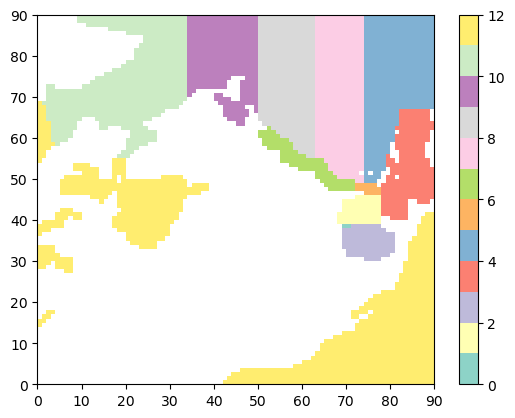

In [3]:
# for regionally-aggregated contribution stores, show map of regions

import matplotlib.pyplot as plt

curr_plot = plt.pcolormesh(ds_forcsens.cell_indexing\
                           .where(ds_forcsens.cell_indexing > -1,np.nan)[10,:,:].values,\
                            cmap='Set3',vmin=0,vmax=12)
plt.colorbar(curr_plot)

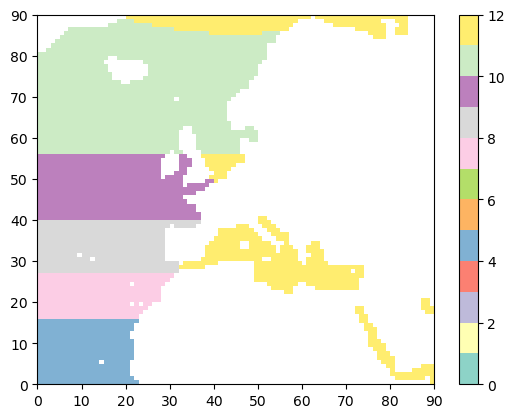

In [4]:
curr_plot = plt.pcolormesh(ds_forcsens.cell_indexing\
                           .where(ds_forcsens.cell_indexing > -1,np.nan)[2,:,:].values,\
                            cmap='Set3',vmin=0,vmax=12)
plt.colorbar(curr_plot)